########################################
TODOS:
- Mapping Network
- Generator Network
- Discriminator Network
- Augmentation/RGBBlock (style vector to RGB)



########################################


In [1]:
import torch
import torchsummary
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
import math
import glob

c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 200
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 256, 256, 3

In [ ]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import numpy as np
import torch
import math
import os
import glob

transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            # transforms.RandomAdjustSharpness(0.25),
            # transforms.RandomHorizontalFlip(0.5),
            # transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            # transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

# Load the data with all of the classes
root = '..\\data\\'
data_dirs = glob.glob(root + '**/*.jpg', recursive=True)
data_dirs = np.array(data_dirs)
data_dirs = data_dirs.flatten()

roots = np.array([root] * len(data_dirs))
data_dirs = np.core.defchararray.add(roots, data_dirs)


# data_list = np.array(data.imgs)

# Get the indices for the train/val/test split of 75/15/15
train_split = math.floor(1 * len(data_dirs))
val_split = math.ceil(0.00 * len(data_dirs))
test_split = val_split * 0

# print(train_split + val_split + test_split, len(data_arr))

# Make sure the splits are correct
assert train_split + val_split + test_split == len(data_dirs)

# Split the dataset randomely
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(data_dirs, [train_split, val_split, test_split], generator=generator)

len(train), len(val), len(test)

In [2]:
import cv2

class GenData(torch.utils.data.Dataset):
    '''
        Data set class to store the feature maps
    
    '''

    def __init__(self, in_data, transform=None):
        # data = np.array(in_data)
        self.input_dirs = in_data
        # self.labels = data[:, 1]
        self.labels = []
        self.input_transform = transform[0]
        self.transform = transform[1]
        self.resize_transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(128)
                                ])


    def __len__(self):
        return len(self.input_dirs)
    
    def __getitem__(self, idx):
        input_dir = self.input_dirs[idx]

        # Load the data
        inputs = cv2.imread(input_dir)
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2RGB)
        # inputs = inputs.swapaxes(0, 2)

        # labels = (int)(self.labels[idx])

        if self.transform:
            inputs = self.input_transform(inputs)
            transformed = self.transform(inputs)

            # labels = self.input_transform(labels)

            return inputs, inputs
        else:
            return inputs, inputs, inputs
        
# Create data loaders
def get_data_loaders(batch_size=1):
    
    train_data = GenData(data_dirs[train.indices], transform=(transform, transform))
    val_data = GenData(data_dirs[val.indices], transform=(transform, transform))
    test_data = GenData(data_dirs[test.indices], transform=(transform, transform))

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
##########################
### Dataset
##########################


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((160, 160)),
    torchvision.transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_data_loaders(
    batch_size=BATCH_SIZE)

In [ ]:
# Checking the dataset

    
# Checking the dataset
print('Validation Set:\n')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

print('\nTraining Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Source Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=False),
                        (1, 2, 0)))

In [17]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    print(inp.size())
    inp = inp.detach().cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
#Mapping Network consisting of 8 linear layers
class MappingNetwork(nn.Module):
    def __init__(self, features):
        super().__init__()


        self.net = nn.Sequential(
            EqualizedWeightsLinearLayer(features, features),
            nn.LeakyReLU(0.2, True),

            EqualizedWeightsLinearLayer(features, features),
            nn.LeakyReLU(0.2, True),

            EqualizedWeightsLinearLayer(features, features),
            nn.LeakyReLU(0.2, True),

            EqualizedWeightsLinearLayer(features, features),
            nn.LeakyReLU(0.2, True),

            EqualizedWeightsLinearLayer(features, features),
            nn.LeakyReLU(0.2, True),

            EqualizedWeightsLinearLayer(features, features),
            nn.LeakyReLU(0.2, True),

            EqualizedWeightsLinearLayer(features, features),
            nn.LeakyReLU(0.2, True),

            EqualizedWeightsLinearLayer(features, features),
            nn.LeakyReLU(0.2, True),

        )
    def forward(self, z):
        z = F.normalize(z, dim=1)
        return self.net(z)


class EqualizedWeightsLinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias):
        super().__init__()

        features = [in_features, out_features]
        self.weight = EqualizedWeight(features)
        self.bias = nn.Parameter(torch.ones(out_features) * bias)
    
    def forward(self, x):
        return F.Linear(x, self.weight(), self.bias)

In [18]:
class EqualizedWeight(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.constant = 1 / math.sqrt(np.prod(shape[1:]))
        self.weight = nn.Parameter(torch.randn(shape))

    def forward(self):
        return self.weight * self.constant

class UpsampleBlock(nn.Module):
    '''
    Block that upsamples image in the Synthesis Network
    ie: 4x4 -> 8x8

    Test: Done
    '''
    def __init__(self):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.kernel = nn.Parameter(torch.tensor([[[[1, 2, 1],[2, 4, 2],[1, 2, 1]]]],
                                                dtype=torch.float), requires_grad=False)

        self.kernel /= self.kernel.sum()
        self.pad = nn.ReflectionPad2d(1)
        self.conv2d = F.conv2d

    def forward(self, x):
        b, c, h, w = x.shape
        x = self.upsample(x)
        x = x.view(-1, 1, h, w)
        x = self.pad(x)
        x = self.conv2d(x, self.kernel)

        return x.view(b, c, h * 2, w * 2)

class ConvModDeMod(nn.Module):
    '''
    Normal convolution BUT: weights are modulated (scaled) by the style vector
    and then de-modulated (formula from the paper)
    '''
    def __init__(self, in_features, out_features, kernel_size, demodulate=True):
        super().__init__()
        self.demodulate = demodulate
        self.out_features = out_features

        self.padding = (kernel_size - 1) // 2

        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])

        self.eps = 1e-8

    def forward(self, x, style_vector):
        b, c, h, w = x.shape
        style_vector = style_vector[:, None , :, None, None]

        weights = self.weight()[None, :, :, :, :]
        # print(weights.shape, style_vector.shape)

        # Modulation step
        weights = weights * style_vector
        # print(f'After: {weights.shape}')

        if self.demodulate:
            sigma_inv = torch.rsqrt((weights ** 2).sum(dim=(2, 3, 4), keepdim=True) + self.eps)

            weights *= sigma_inv

        # Prep the inputs and weight for convolution
        x = x.reshape(1, -1, h, w)
        _, _, *ws = weights.shape

        weights = weights.reshape(b * self.out_features, *ws)

        x = F.conv2d(x, weights, padding=self.padding, groups=b)

        # Reshape to proper sizes
        x = x.reshape(-1, self.out_features, h, w)

        return x

class WToRGB(nn.Module):
    '''
    Converts a latent vector to RGB image
    '''

    def __init__(self, w_size, features):
        super().__init__()

        self.to_style = nn.Linear(w_size, features)

        self.conv = ConvModDeMod(features, 3, 1, False)
        self.bias = nn.Parameter(torch.zeros(3))
        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x, w):
        style_vector = self.to_style(w)
        x = self.conv(x, style_vector)

        return self.activation(x + self.bias[None, :, None, None])


class StyleBlock(nn.Module):
    '''
    Takes a w vector, performs an affine transformation (linear layer), to get style vector.
    Modulates the convolution weights using this style vector and then returns it.
    '''
    def __init__(self, w_size, in_features, out_features):
        super().__init__()

        # This is the affine transformation
        self.to_style = nn.Linear(w_size, in_features) # Replace with EqualizedLinear layer
        self.conv = ConvModDeMod(in_features, out_features, 3)
        self.scale_noise = nn.Parameter(torch.zeros(1))
        self.bias = nn.Parameter(torch.zeros(out_features))

        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x, w, noise):
        s = self.to_style(w)
        x = self.conv(x, s)

        if noise is not None:
            x = x + self.scale_noise[None, :, None, None] * noise
        x = self.activation(x + self.bias[None, :, None, None])

        return x
    
class SynthesisBlock(nn.Module):
    def __init__(self, w_size, in_features, out_features):
        super().__init__()

        self.style_block1 = StyleBlock(w_size, in_features, out_features)

        self.style_block2 = StyleBlock(w_size, out_features, out_features)

        self.to_rgb = WToRGB(w_size, out_features)

    def forward(self, x, ws, noise):
        # print("3: ", ws.shape)
        x = self.style_block1(x, ws[:, 0], noise[0])
        x = self.style_block2(x, ws[:, 1], noise[1])

        return x, self.to_rgb(x, ws[:, 2])

        
class SynthesisNetwork(nn.Module):
    def __init__(self, batch_size=16, w_size=512):
        super().__init__()

        self.sizes = [4, 8, 16, 32, 64, 128, 256]
        self.features = [512, 512, 512, 512, 256, 128, 64]

        self.init_noise = nn.Parameter(torch.randn([batch_size, w_size, 4, 4]))

        self.style_block = StyleBlock(w_size, self.features[0], self.features[0])
        self.to_rgb = WToRGB(w_size, self.features[0])

        blocks = []
        for i in range(1, len(self.features)):
            blocks.append(SynthesisBlock(w_size, self.features[i - 1], self.features[i]))

        self.blocks = nn.ModuleList(blocks)

        self.upsample = UpsampleBlock()

    def forward(self, ws, input_noise=None):
        if input_noise is None:
            input_noise = nn.Parameter(torch.rand([7, 2]))

        # Initial 4x4 Block
        x = self.style_block(self.init_noise, ws[:, 0], input_noise[0][1])
        rgb = self.to_rgb(x, ws[:, 1])

        w_idx = 1

        # Upscale image as you go (like progressive gan)
        for i in range(1, len(self.features)):
            x = self.upsample(x) 

            x, rgb_new = self.blocks[i - 1](x, ws[:, w_idx:w_idx + 3], input_noise[i]) # + 3 since rgb layer is not considered in adition
            w_idx += 2 # Increment the index of ws by 2 since there are 2 convs per synthesis block

            rgb = self.upsample(rgb) + rgb_new
        

        return rgb

In [19]:
# Need to quantize model (use .half()) or it won't fit on my GPU
test_ws = torch.rand([16, 14, 512]).half().cuda()
test_noise = torch.rand([7, 2]).half().cuda()
net = SynthesisNetwork().half().cuda()
out = net(test_ws, test_noise)
out.shape

torch.Size([16, 3, 256, 256])

torch.Size([3, 518, 2066])


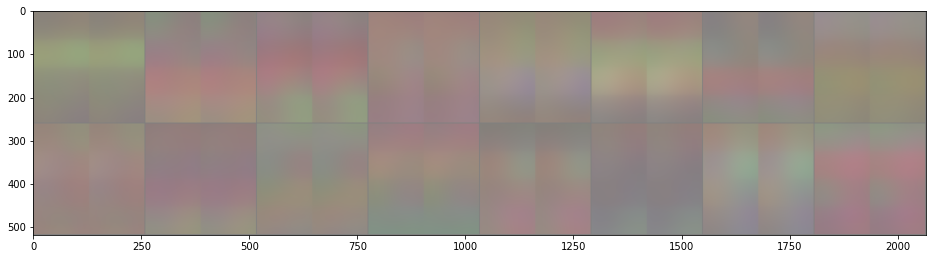

In [20]:
imshow(torchvision.utils.make_grid(out))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):

        self.features = [64, 128, 256, 512, 512, 512]
        